<center><h1> Intelligent Systems </h1>
    <h2> <b>Assignment #1</b> </h2>
    <h3> Done by: Ghinea Cristian and Varga Zoltan </h3></center>

<h3> Abstract </h3>
<p> We decided to examine a dataset which holds data about the shopping habits of citizens living in Istanbul. It holds data related to 10 shopping malls collected between 2021 and 2023. As the authors state it should provide a "comprehensive view of shopping habits in Istanbul".</p>
<p> The model built by us is able to predict <i> the likelihood of someone paying by credit card, debit card or cash. </i></p>
<p> <i>The dataset can be downloaded from here: <a href="https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset"> click here </a></i><p>

In [167]:
# Start by including some essential libraries

import pandas as pd
import numpy as np
import seaborn as sns


from pandas.plotting import scatter_matrix
from seaborn import scatterplot, heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [168]:
# read the dataset
df = pd.read_csv("./dataset/customer_shopping_data.csv")

<h3> Start by taking a look at our data </h3>

<p> 
    Here we can se that the types of the columns are as expected. This fact predicts us that there is no garbage (at least no mix of types within the columns).
</p>

In [169]:
df.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [170]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

<p>
    This description gives us a better insight. The first two columns seem to be unique identifiers of the rows as there are as many unique values there as rows. The first decision of ours will be to delete these two columns because unique identifiers don't hold meaningful information.
</p>
<p>
    Going further, the remaining columns seem to have correct data, without any noise. We must mention that the age is neatly distributed, which is promising as this can be an important predictor.
</p>

In [171]:
df.describe(include="all")

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
count,99457,99457,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457
unique,99457,99457,2,NaN,8,NaN,NaN,3,797,10
top,I138884,C241288,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul
freq,1,1,59482,NaN,34487,NaN,NaN,44447,159,19943
mean,NaN,NaN,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN
std,NaN,NaN,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN
min,NaN,NaN,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN
25%,NaN,NaN,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN
50%,NaN,NaN,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN
75%,NaN,NaN,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN


In [172]:
# delete the columns containing unique identifiers
df = df[['gender','age','category','quantity','price','payment_method','invoice_date','shopping_mall']]

In [173]:
# check what categories we have
df['category'].unique()

array(['Clothing', 'Shoes', 'Books', 'Cosmetics', 'Food & Beverage',
       'Toys', 'Technology', 'Souvenir'], dtype=object)

<p>
    We decided to encode the categories, however we might use one-hot encoding in the future.
</p>

In [174]:
# df['category_num'] = 0
# df.loc[df['category'] == 'Clothing', 'category_num'] = 0
# df.loc[df['category'] == 'Shoes', 'category_num'] = 1
# df.loc[df['category'] == 'Books', 'category_num'] = 2
# df.loc[df['category'] == 'Cosmetics', 'category_num'] = 3
# df.loc[df['category'] == 'Food & Beverage', 'category_num'] = 4
# df.loc[df['category'] == 'Toys', 'category_num'] = 5
# df.loc[df['category'] == 'Technology', 'category_num'] = 6
# df.loc[df['category'] == 'Souvenir', 'category_num'] = 7

In [175]:
# check the payment methods
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

In [176]:
# one hot encode them here in order to have them on the scatter plot
df['payment_method_cash'] = 0
df['payment_method_credit'] = 0
df['payment_method_debit'] = 0

df.loc[df['payment_method'] == 'Credit Card', 'payment_method_credit'] = 1
df.loc[df['payment_method'] == 'Debit Card', 'payment_method_debit'] = 1
df.loc[df['payment_method'] == 'Cash', 'payment_method_cash'] = 1

In [177]:
df['shopping_mall'].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

<p>
    As the names of the malls didn't provide us with any information, we opted to categorize them into two groups: expensive (1) and affordable (0) malls. We conducted research online to distinguish between the two.
</p>

In [178]:
df['mall_category'] = ''
df.loc[df['shopping_mall'] == 'Kanyon','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Forum Istanbul','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Metrocity','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Metropol AVM','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Istinye Park','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Mall of Istanbul','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Emaar Square Mall','mall_category'] = 1
df.loc[df['shopping_mall'] == 'Cevahir AVM','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Viaport Outlet','mall_category'] = 0
df.loc[df['shopping_mall'] == 'Zorlu Center','mall_category'] = 1

In [179]:
# df['gender_num'] = 0
# df.loc[df['gender'] == 'Male', 'gender_num'] = 1

In [180]:
# categorise the years as the prefference of using debit/credit card or cash does not change over 1 year, but over a generation
# we grouped them in 8 year intervals

df['age_cat_1'] = 0
df['age_cat_2'] = 0
df['age_cat_3'] = 0
df['age_cat_4'] = 0
df['age_cat_5'] = 0
df['age_cat_6'] = 0
df['age_cat_7'] = 0

df.loc[df['age'].between(18,25), 'age_cat_1'] = 1
df.loc[df['age'].between(26,33), 'age_cat_2'] = 1
df.loc[df['age'].between(34,41), 'age_cat_3'] = 1
df.loc[df['age'].between(42,49), 'age_cat_4'] = 1
df.loc[df['age'].between(50,57), 'age_cat_5'] = 1
df.loc[df['age'].between(58,65), 'age_cat_6'] = 1
df.loc[df['age'].between(66,73), 'age_cat_7'] = 1

<p> 
    We extracted only the year and the month of the payment, as the day is not relevant. By the month maybe we can observe some patterns regarding high-sale periods such as holidays. At first we wanted to remove the year as well, but we quickly changed our minds as the preference for paying with card over cash drastically changed during the pandemic, and the dataset captures this period.
</p>

In [181]:
df['year'] = pd.to_datetime(df['invoice_date'],format='%d/%m/%Y').dt.year
df['month'] = pd.to_datetime(df['invoice_date'],format='%d/%m/%Y').dt.month

In [182]:
df['price'].describe()

count    99457.000000
mean       689.256321
std        941.184567
min          5.230000
25%         45.450000
50%        203.300000
75%       1200.320000
max       5250.000000
Name: price, dtype: float64

In [183]:
df['payment_method'].unique()

array(['Credit Card', 'Debit Card', 'Cash'], dtype=object)

In [185]:
# make the target value numerical
df['payment_method_cat'] = 0
df.loc[df['payment_method'] == 'Cash','payment_method_cat'] = 1
df.loc[df['payment_method'] == 'Debit Card','payment_method_cat'] = 2
df.loc[df['payment_method'] == 'Credit Card','payment_method_cat'] = 3

<h3> Separate the test set and the training set </h3>

As in the followings we will dive deeper into the dataset we must lock the test set away. As we have plenty of data we can afford a 80% - 20% ratio between the size of the training and the test set.

In [186]:
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

<h3> Data visualization </h3>

We copied the training set in order not to modify them by chance. We made a scatter plot to visualize the eventual correlation between the columns. Unfortunately we have only a few columns that contain numerical values, so we couldn't draw a conclusion from these plots. But below we combined some features in graphs that we considered important.

In [187]:
copy_dev_df = dev_df.copy()

In [188]:
#m = scatter_matrix(copy_dev_df,figsize=(15,15))

We suspected a high correlation between the age of a customer and the payment method it will use. So we tried to visualize these two. </p> <p> To our surprise there wasn't a high correlation between the age category and the payment method used. More specifically there is only a subtle change in the number of purchases where cash was used in the 4th and 5th category. This means that we cannot conclude that the young generation is more prone to using card than cash when making a payment.

<Axes: xlabel='age_cat'>

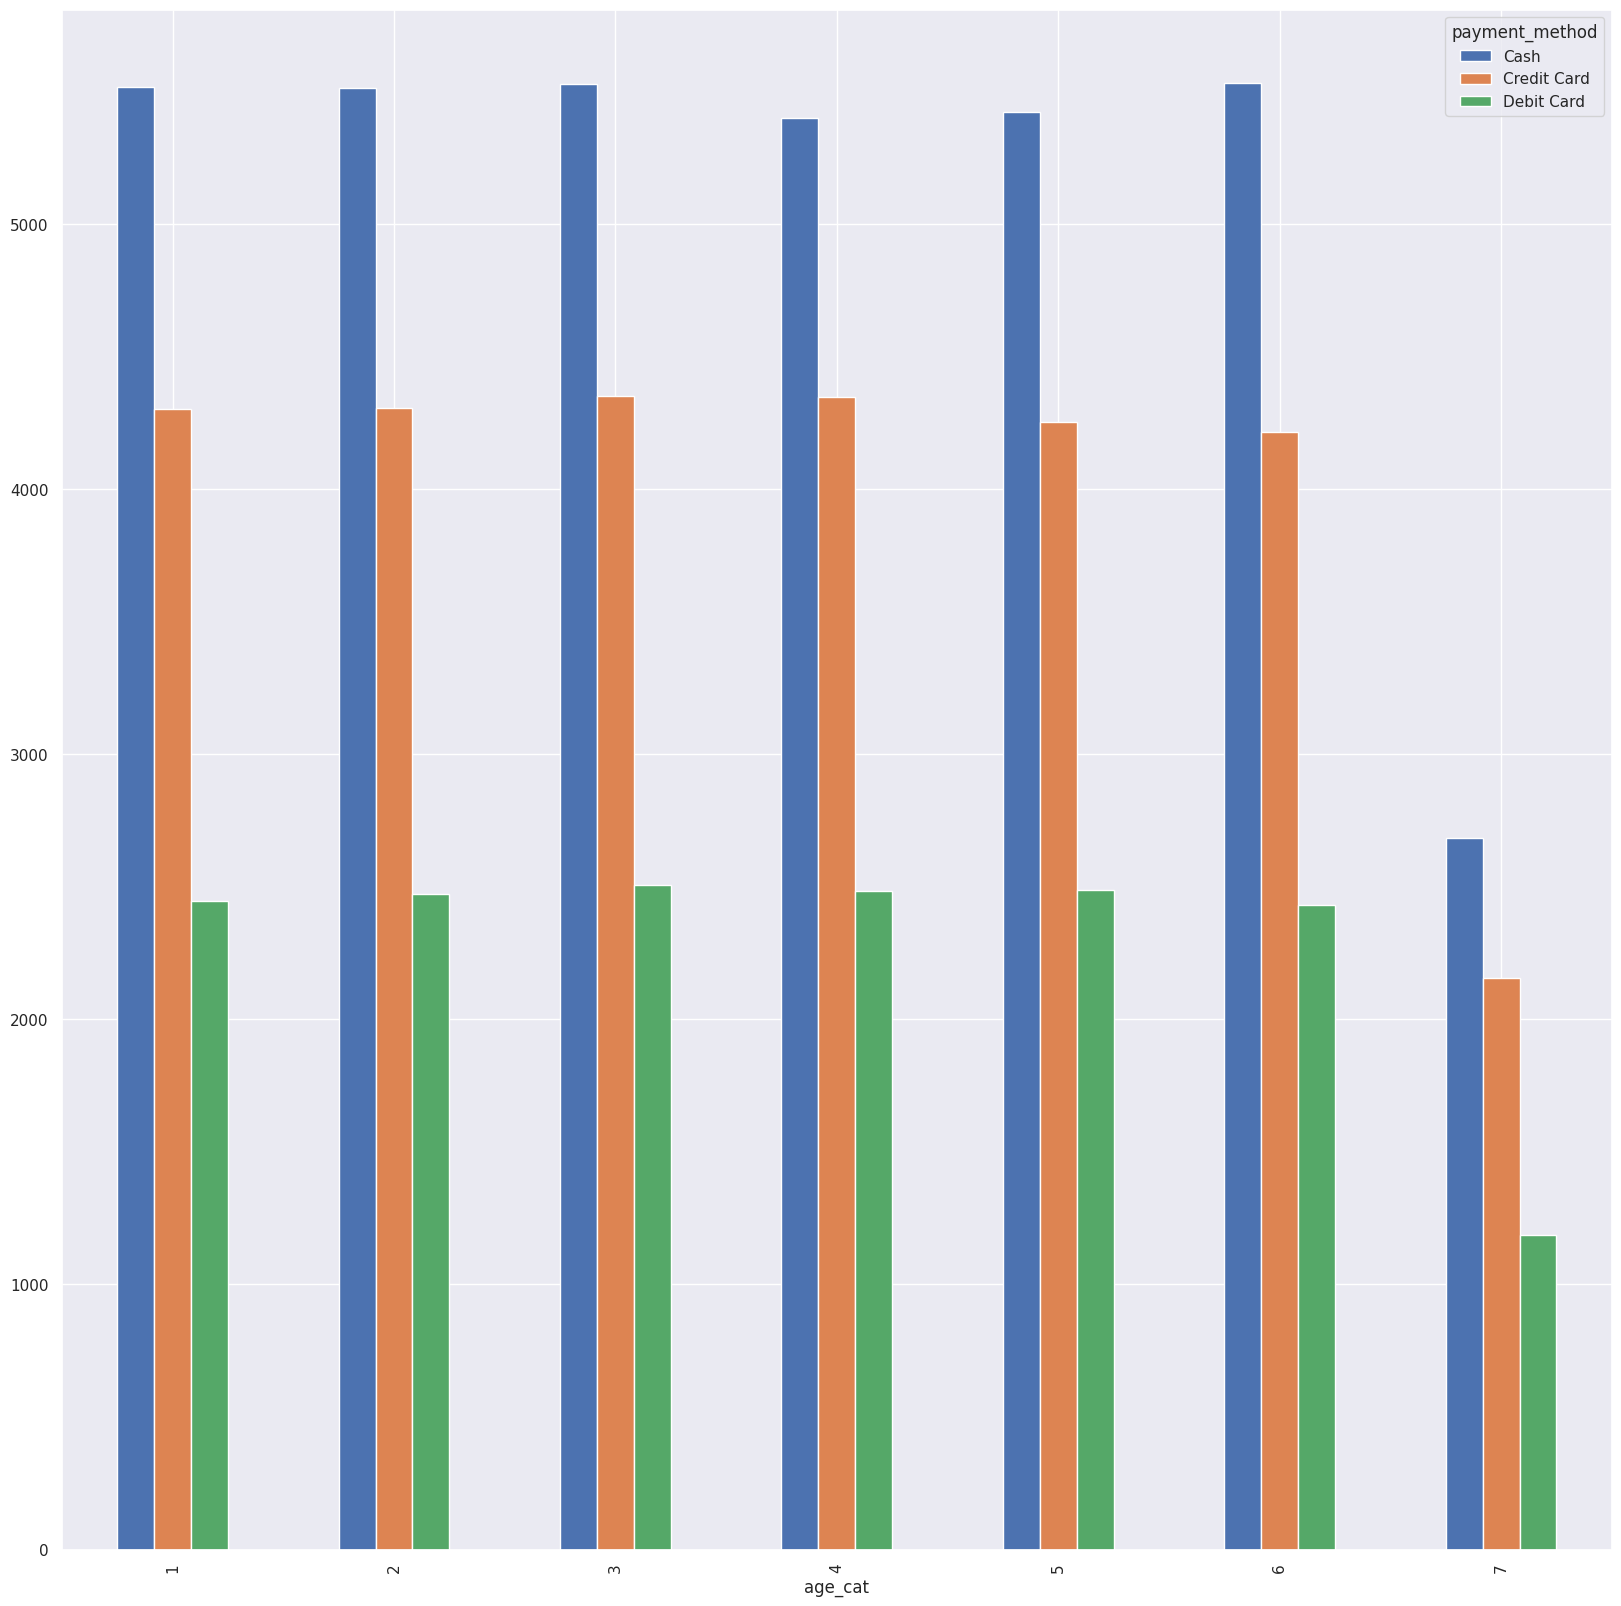

In [195]:
# make the categories in one column, remove that column afterwards
copy_dev_df['age_cat'] = 0
copy_dev_df.loc[copy_dev_df['age'].between(18,25), 'age_cat'] = 1
copy_dev_df.loc[copy_dev_df['age'].between(26,33), 'age_cat'] = 2
copy_dev_df.loc[copy_dev_df['age'].between(34,41), 'age_cat'] = 3
copy_dev_df.loc[copy_dev_df['age'].between(42,49), 'age_cat'] = 4
copy_dev_df.loc[copy_dev_df['age'].between(50,57), 'age_cat'] = 5
copy_dev_df.loc[copy_dev_df['age'].between(58,65), 'age_cat'] = 6
copy_dev_df.loc[copy_dev_df['age'].between(66,73), 'age_cat'] = 7

# Create a pivot table to capture the payment methods used for each age category
age_payment_method_combined = copy_dev_df.pivot_table(index='age_cat', columns='payment_method', aggfunc='count')['age']
# Plot the table
age_payment_method_combined.plot.bar()

<p>The drop in the overall purchases in the 7th age category it is most probably due to the limited number of rows that are covering this age group. Also from the following plot one can see that there is an even distribution of the age groups.</p>

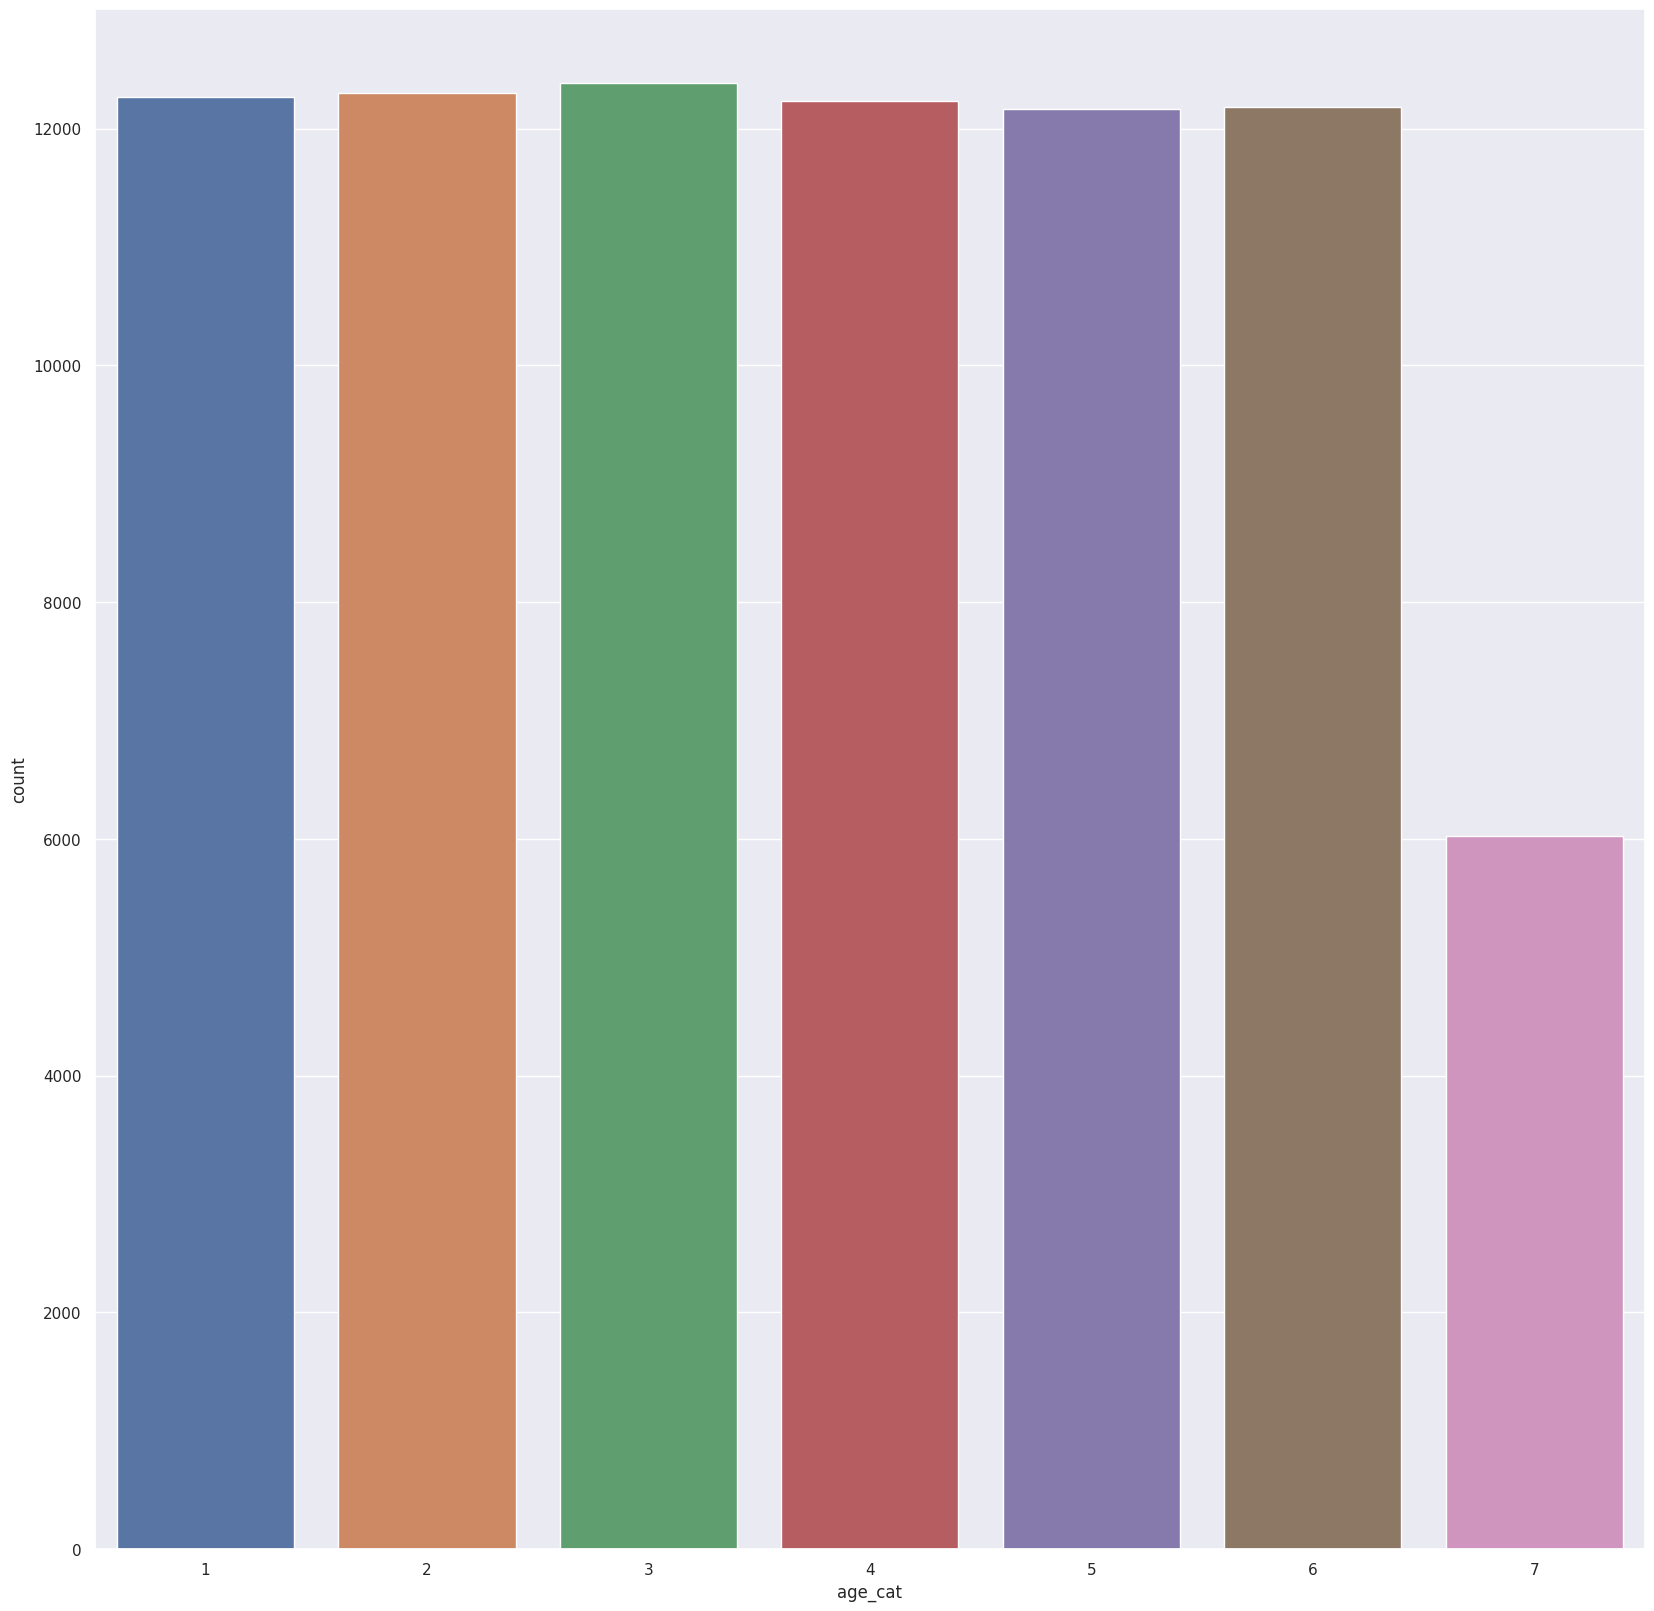

In [194]:
copy_dev_df.sort_values(by='age_cat', ascending=True)
sns.countplot(x = 'age_cat',
              data = copy_dev_df)

sns.set(rc={'figure.figsize':(20,20)})

<b>Sansele sa cumpere cineva cu card sunt mai mari in jurul sarbatorilor din iarna (black-friday -> Christmas). Diferenta dintre current date si mean of [BF, Xmas].?? major turkish celebrations??</b>

We observed that there is a big difference between the number of cash payments and debit_card payments. We will tackle this issue by using a stratified k fold when splitting up the train and the validation sets. By this we will eliminate the chance of having just cash payments in one of the sets.

<Axes: xlabel='payment_method', ylabel='count'>

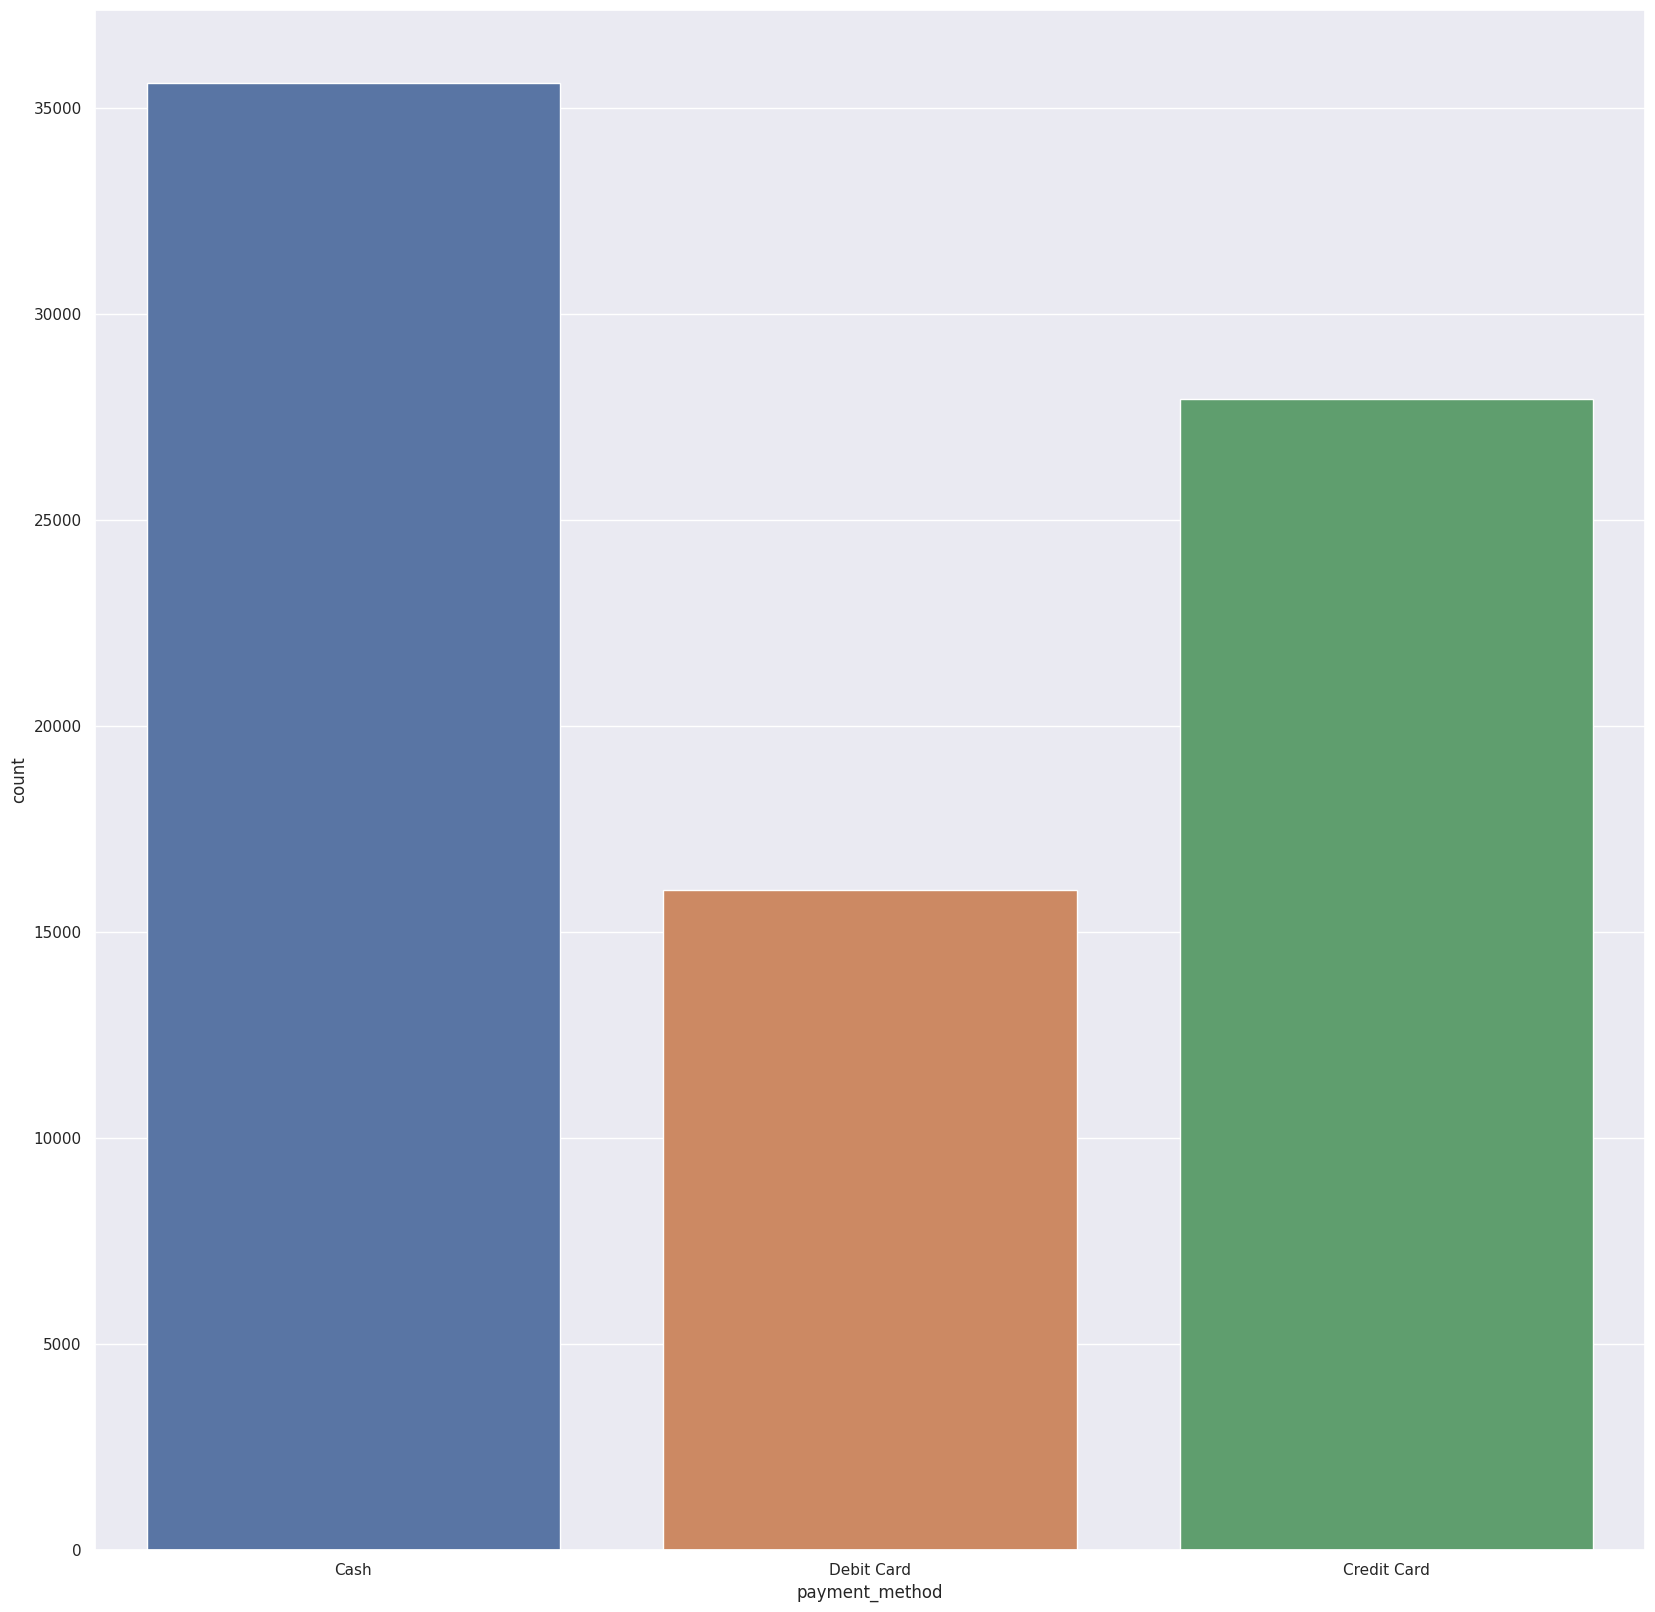

In [192]:
copy_dev_df.sort_values(by='payment_method', ascending=True)
sns.countplot(x = 'payment_method', data = copy_dev_df)

<p> 
    Next, we ploted the number number of payments made by all three payment methods along the price axis. From this we conluded that there are only a few payments above 3000. So we should remove the examples above 3000.
</p>

<Axes: xlabel='price'>

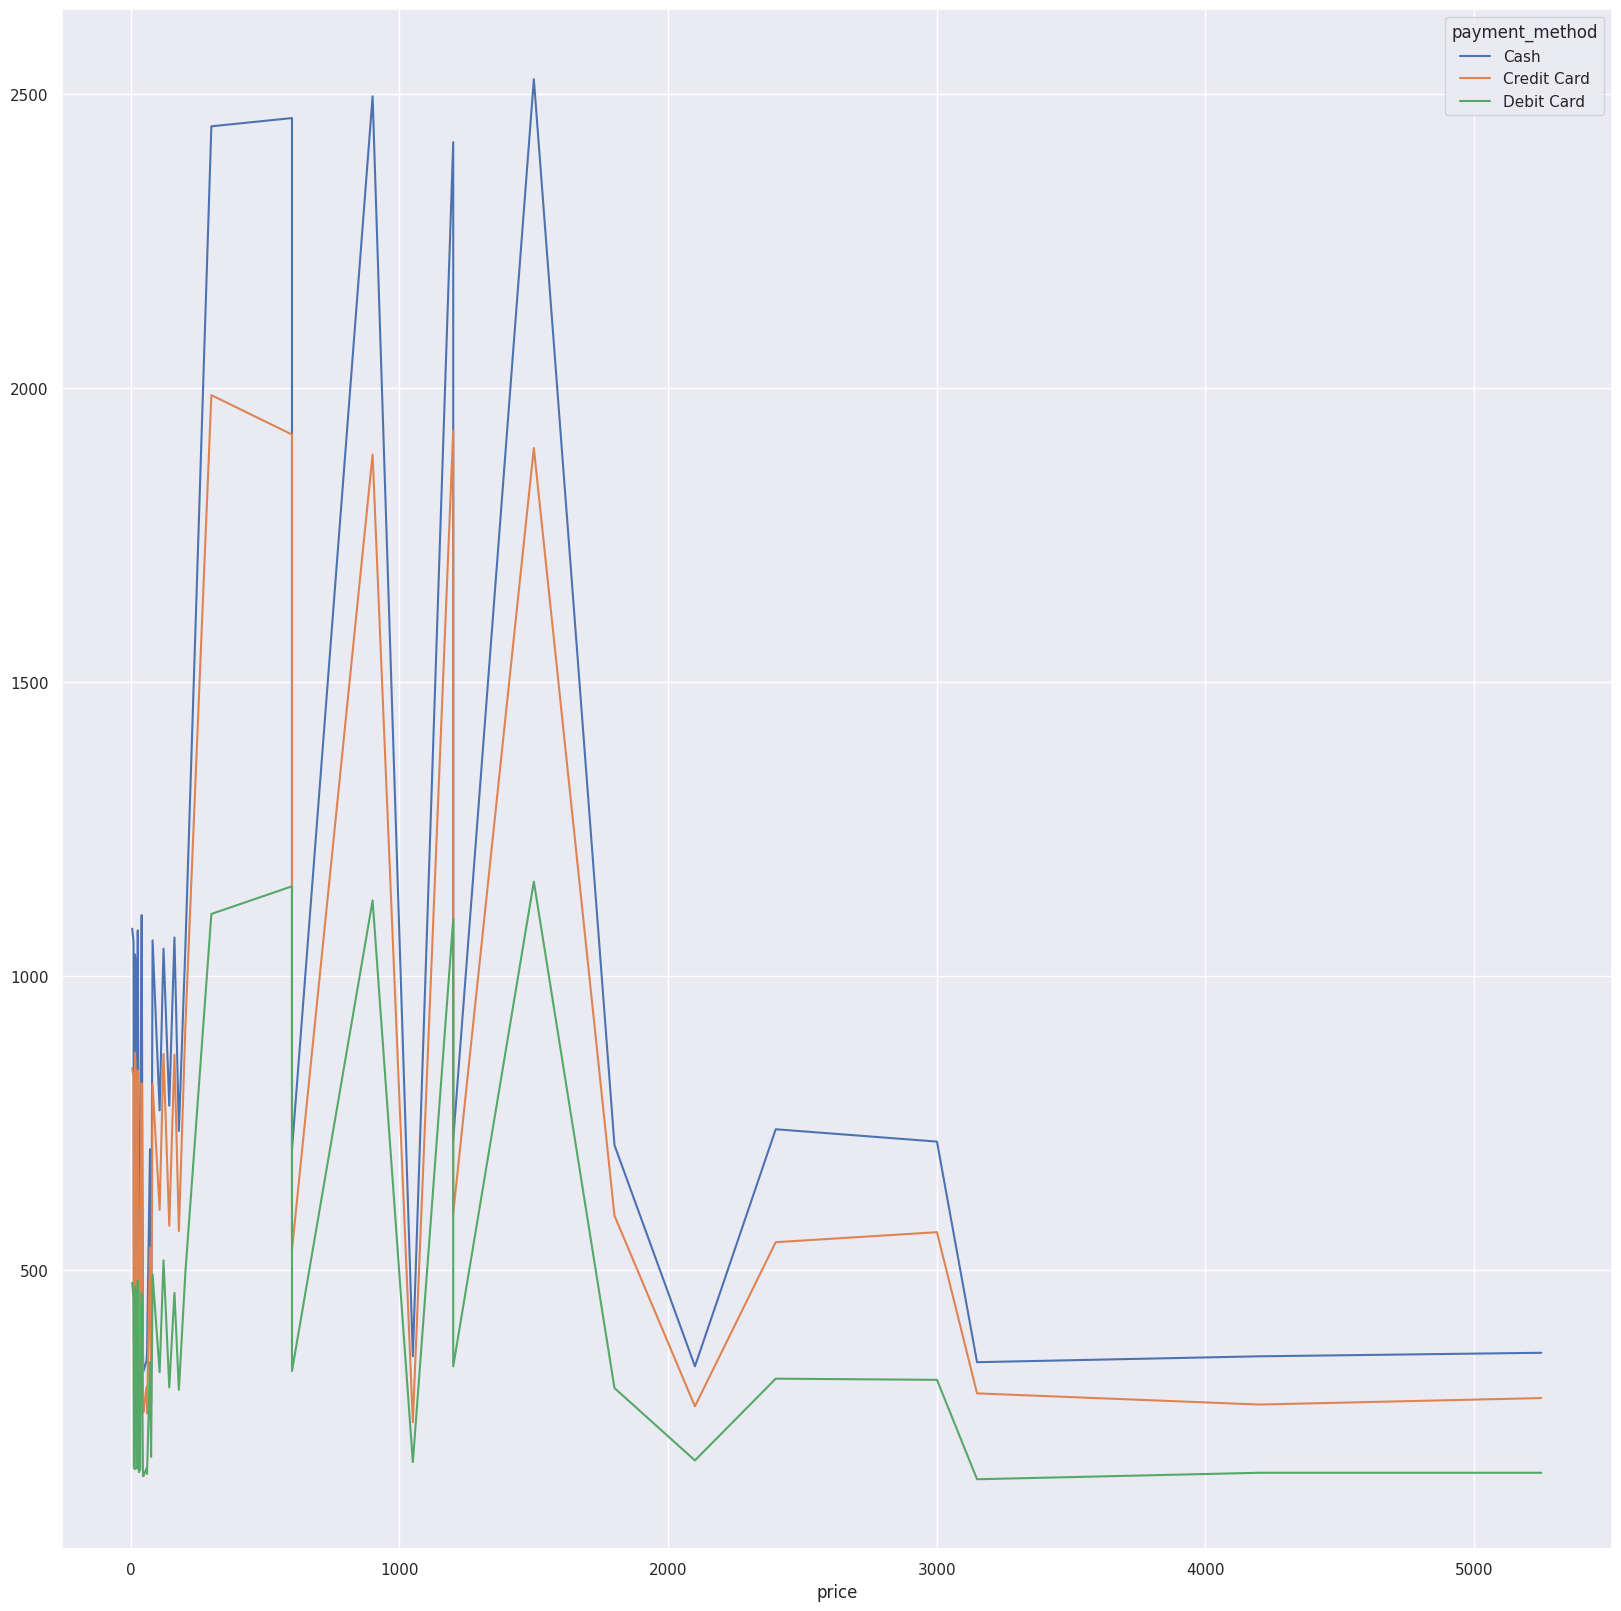

In [193]:
# Create a pivot table to capture the payment methods used along prices
age_payment_method_combined = copy_dev_df.pivot_table(index='price', columns='payment_method', aggfunc='count')['age']
# Plot the table
age_payment_method_combined.plot.line()

In [196]:
copy_dev_df = copy_dev_df[copy_dev_df['price'] <= 3250]

<p>
    Now the chart looks better, since it focuses more on the price range that is representative. From this we observed some steep drops, that still havent been addressed.
</p>

<Axes: xlabel='price'>

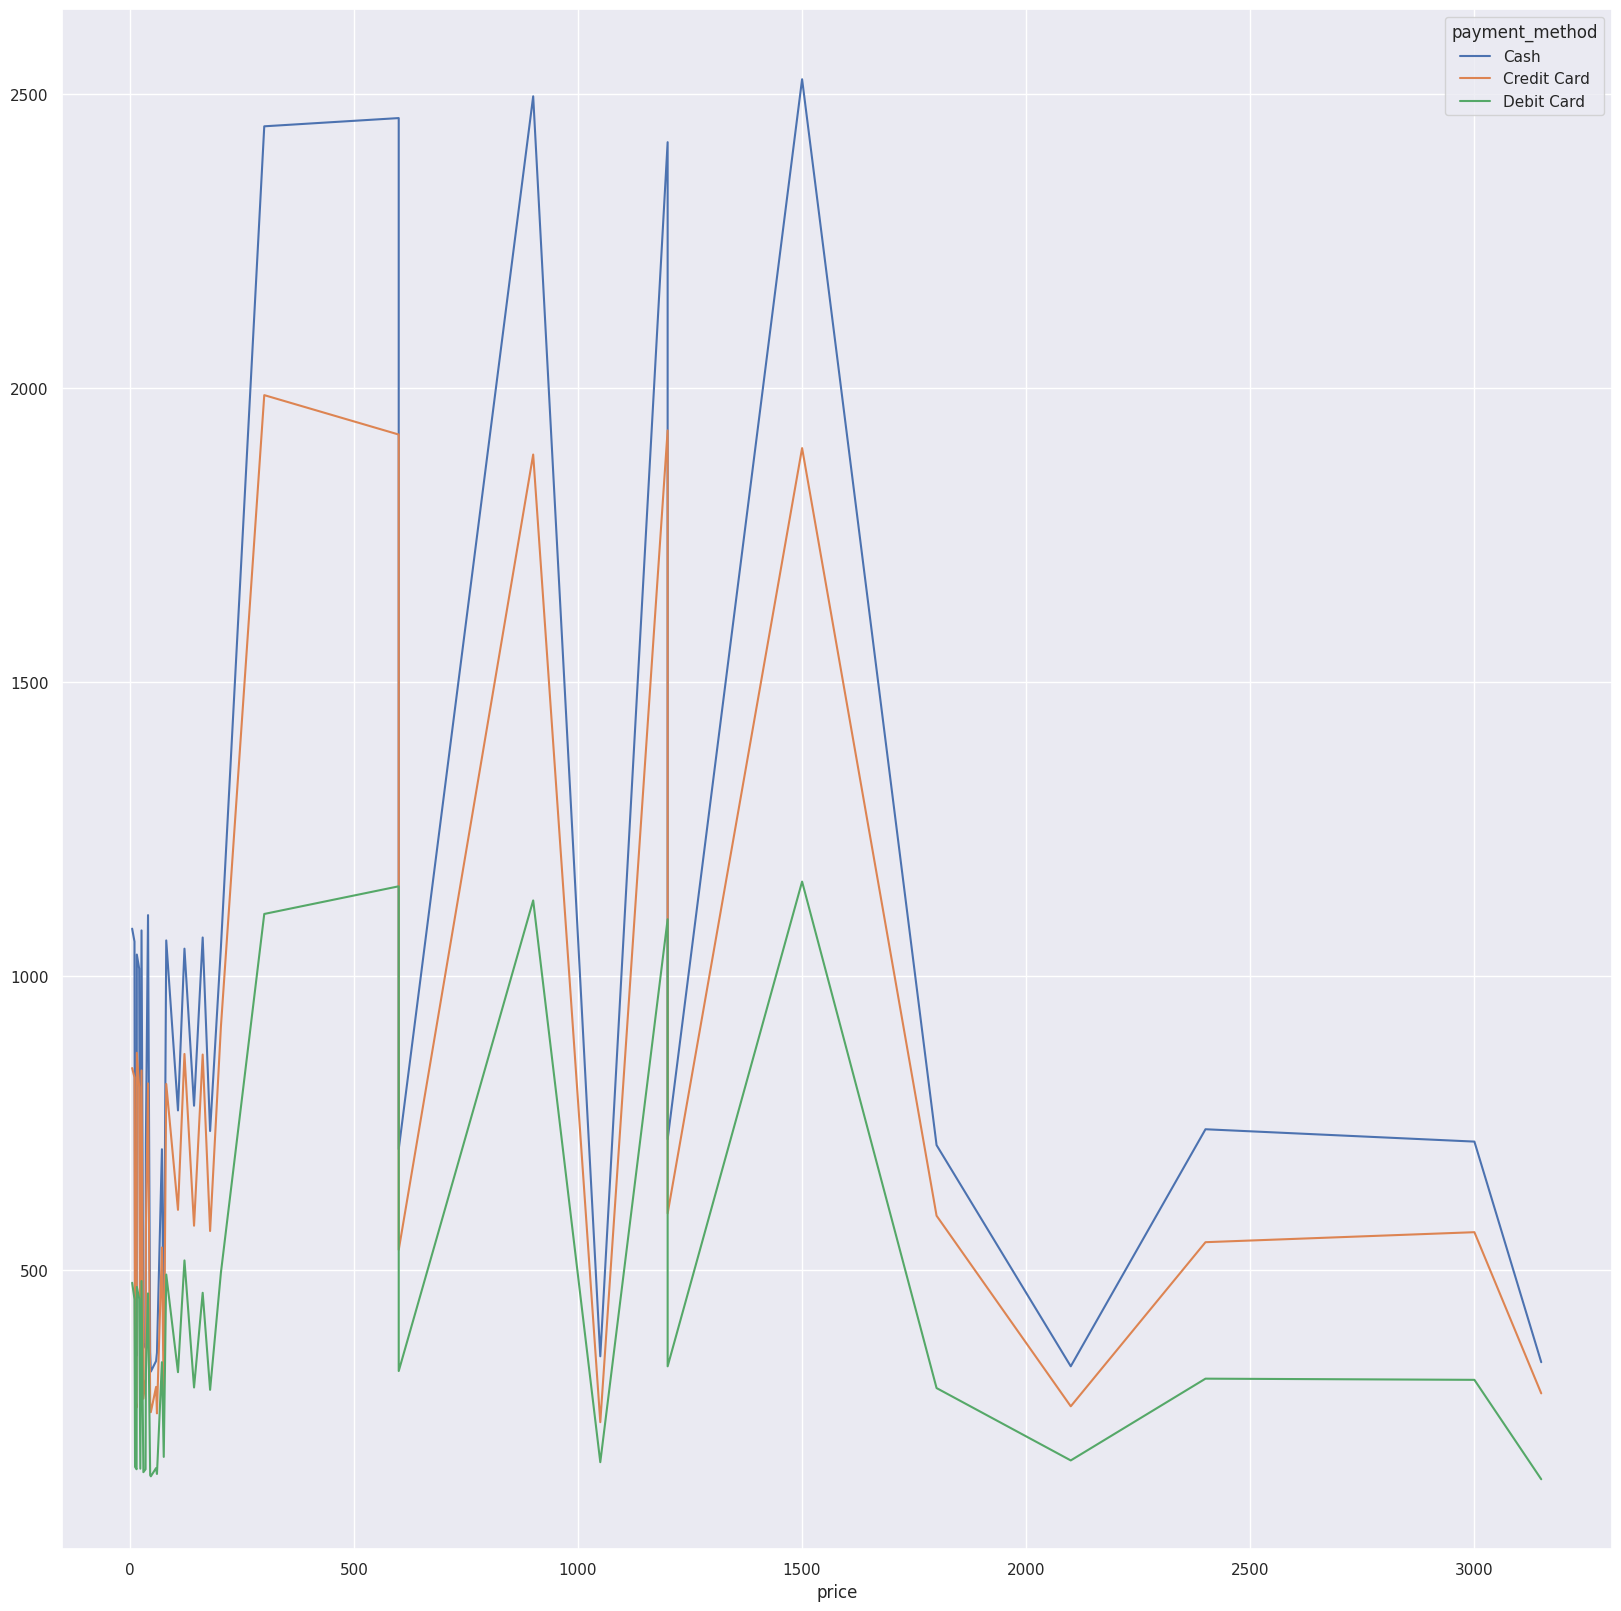

In [197]:
# Create a pivot table to capture the payment methods used along prices
age_payment_method_combined = copy_dev_df.pivot_table(index='price', columns='payment_method', aggfunc='count')['age']
# Plot the table
age_payment_method_combined.plot.line()

From this plot we can see the cause of the steep peeks and drops. The amount of the payment is not evenly distributed. 

<Axes: xlabel='price'>

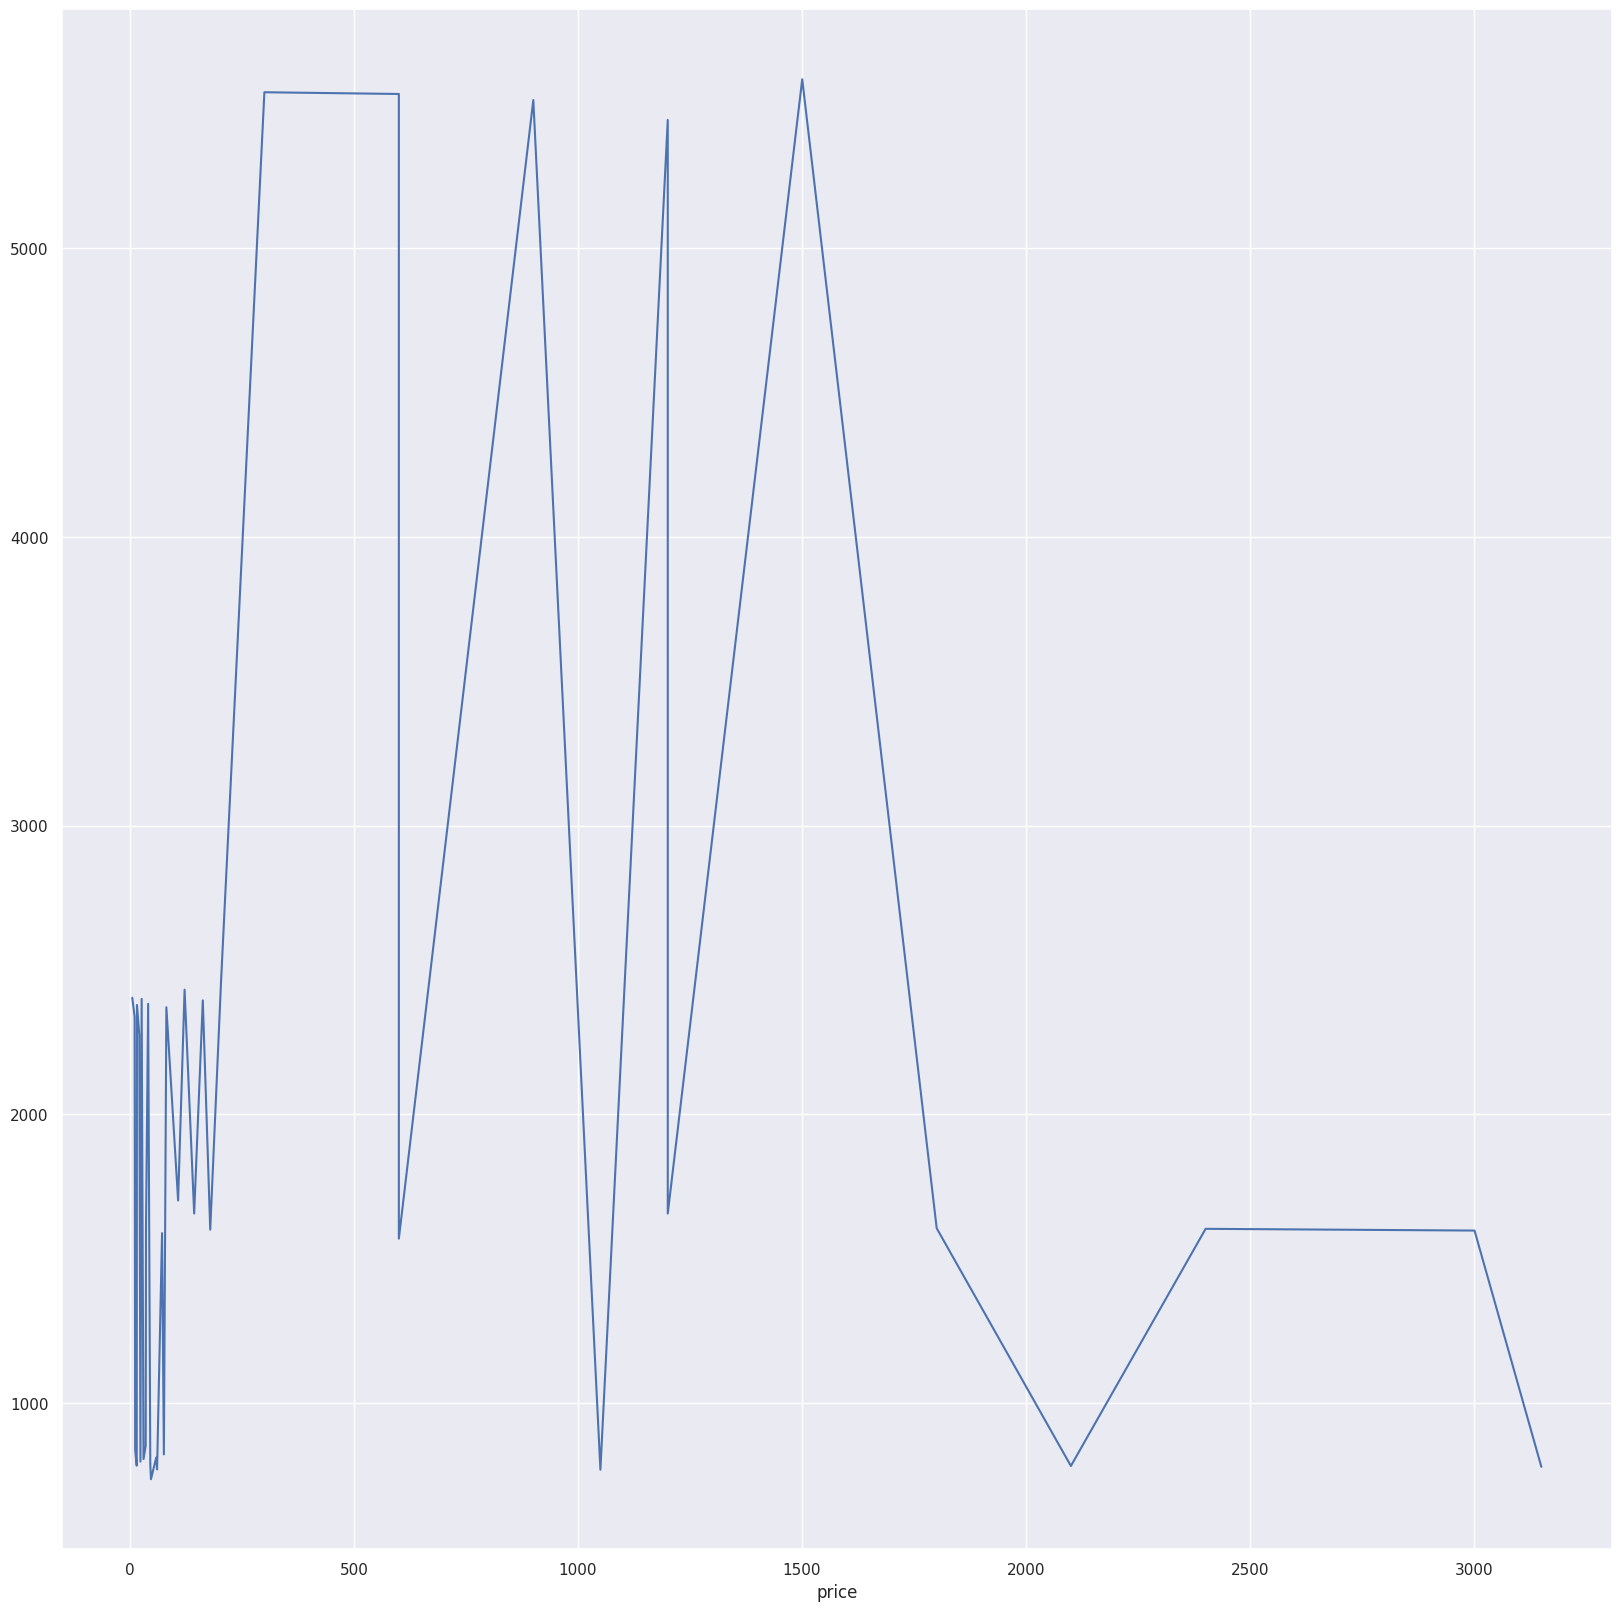

In [198]:
price_count = copy_dev_df.groupby('price').count()['gender']
price_count.plot.line(x = 'price', y = 'gender')

<p>
    We can observe that there is are many transactions at the beginning of the year, there is a peak in the summer (maybe this can be a period when there are more tourists in the city), but a low point around september. The peak at the beginning of the year is very interesting, because at the end of the year there isn't a climbing tendency that would assure continuity along the timeline.
</p>

<Axes: xlabel='month', ylabel='count'>

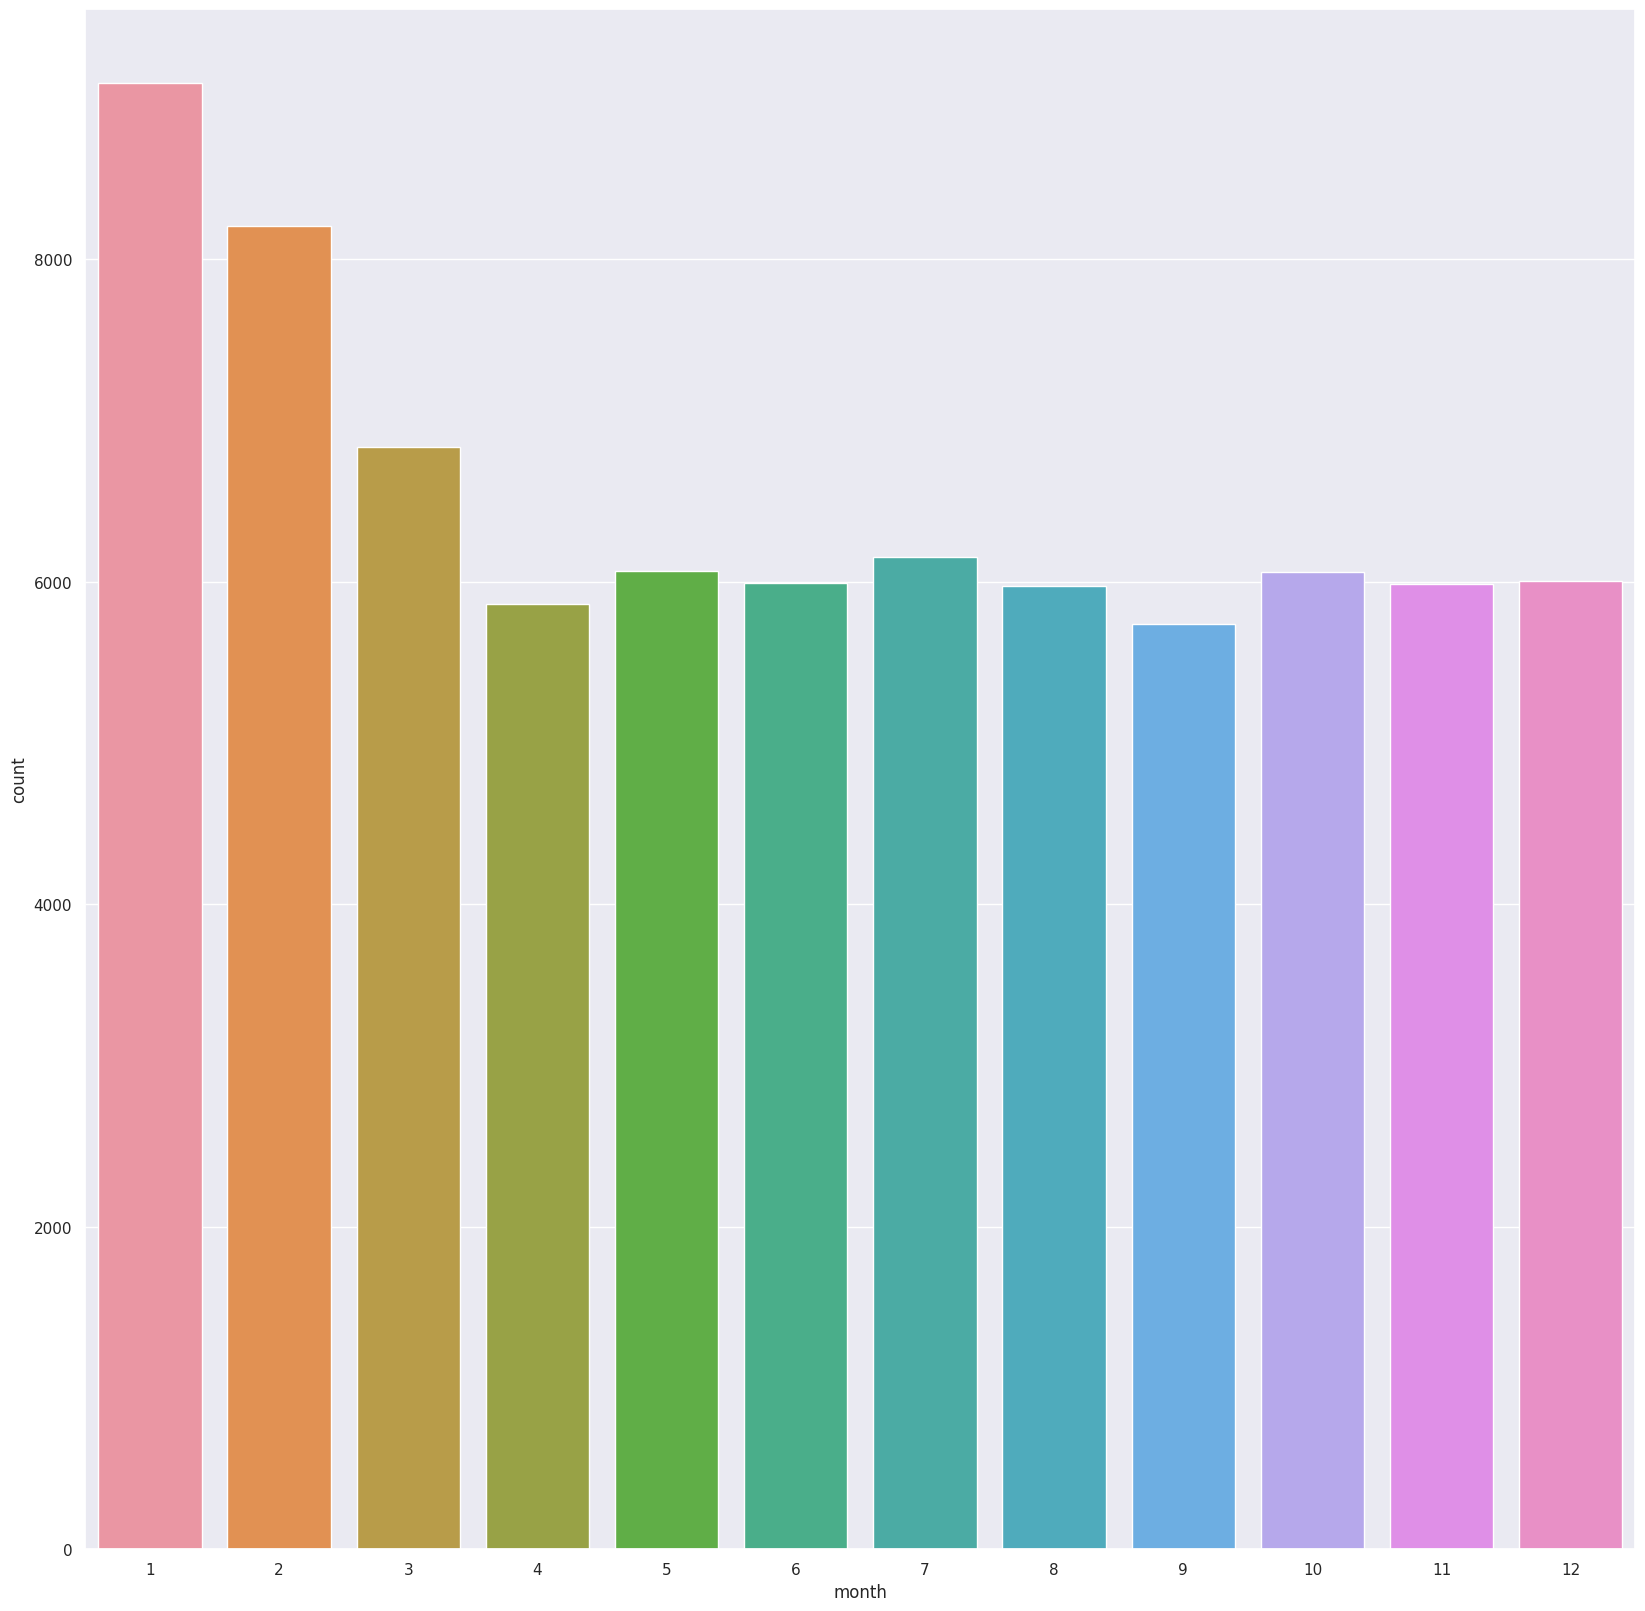

In [199]:
sns.countplot(x = 'month',
              data = copy_dev_df)

<p>
    It can be seen a small increase in correlation between the the payment method, specifically payments made by debit card and age, also the period of the year seems to be slightly more corellated with the payment method. Based on these observations we will make feature engineering.
</p>

In [200]:
corr_matrix = copy_dev_df.corr()
corr_matrix['payment_method_cash'].sort_values(ascending=False)

/tmp/ipykernel_6273/723102843.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = copy_dev_df.corr()


payment_method_cash      1.000000
month                    0.005815
age_cat_6                0.005776
age_cat_1                0.002108
price                    0.000776
age_cat_2                0.000771
age                      0.000729
age_cat                  0.000152
age_cat_5               -0.000480
quantity                -0.000560
year                    -0.001490
age_cat_3               -0.001506
age_cat_7               -0.001766
age_cat_4               -0.005362
payment_method_debit    -0.451953
payment_method_credit   -0.661949
payment_method_cat      -0.915327
Name: payment_method_cash, dtype: float64

In [201]:
corr_matrix['payment_method_credit'].sort_values(ascending=False)

payment_method_credit    1.000000
payment_method_cat       0.907752
year                     0.004631
age_cat_4                0.004353
age_cat_7                0.003921
quantity                 0.002525
age                      0.000213
age_cat_3                0.000207
age_cat                  0.000124
age_cat_1               -0.000180
age_cat_2               -0.001116
age_cat_5               -0.001728
price                   -0.002030
age_cat_6               -0.004422
month                   -0.004644
payment_method_debit    -0.369459
payment_method_cash     -0.661949
Name: payment_method_credit, dtype: float64

In [202]:
corr_matrix['payment_method_debit'].sort_values(ascending=False)

payment_method_debit     1.000000
payment_method_cat       0.054449
age_cat_5                0.002651
age_cat_3                0.001621
age_cat_4                0.001468
price                    0.001454
age_cat_2                0.000372
age_cat                 -0.000336
age                     -0.001158
month                   -0.001682
age_cat_6               -0.001898
quantity                -0.002310
age_cat_1               -0.002400
age_cat_7               -0.002477
year                    -0.003664
payment_method_credit   -0.369459
payment_method_cash     -0.451953
Name: payment_method_debit, dtype: float64

<h3> Feature engineering</h3>

In [203]:
dev_df.describe()

copy_dev_df.columns

Index(['gender', 'age', 'category', 'quantity', 'price', 'payment_method',
       'invoice_date', 'shopping_mall', 'payment_method_cash',
       'payment_method_credit', 'payment_method_debit', 'mall_category',
       'age_cat_1', 'age_cat_2', 'age_cat_3', 'age_cat_4', 'age_cat_5',
       'age_cat_6', 'age_cat_7', 'year', 'month', 'payment_method_cat',
       'age_cat'],
      dtype='object')

<h3> Data preprocessing </h3>

In [205]:
numeric_features = ['quantity','price','age_cat_1','age_cat_2','age_cat_3','age_cat_4','age_cat_5','age_cat_6','age_cat_7', 'year', 'month', 'mall_category']
nominal_features = ['gender','category']

features = ['quantity','price','age_cat_1','age_cat_2','age_cat_3','age_cat_4','age_cat_5','age_cat_6','age_cat_7', 'year', 'month', 'mall_category','gender','category']
target_value = ['payment_method']

In [206]:
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(missing_values=np.nan,strategy="mean")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("nom", Pipeline([
        ("binarizer", OneHotEncoder(handle_unknown="ignore"))
    ]), nominal_features)    
], remainder = "passthrough")

<h3> Model building </h3>

In [207]:
# Separate the features from the target value
dev_X = copy_dev_df[features]
test_X =  test_df[features]

dev_y = copy_dev_df['payment_method_cat'].values
test_y = test_df['payment_method_cat'].values

# Create a splitter that splits the data into training set (60% of the original) and validation set (20% of the original)
splitter = ShuffleSplit(n_splits = 1, train_size = 0.75, random_state = 2) 

In [208]:
# Make a pipeline that contains the preprocessor and the regressor
rf = Pipeline([
    ("preprocessor",preprocessor),
    ("predictor",RandomForestClassifier(random_state=42, n_estimators=40,max_depth=5))
])

# Give the possible values to the hyperparameter n (no. of neighbors)
rf_params = {"predictor__n_estimators": [10,40,75,100],
             "predictor__max_depth": [5,10,20]}

# Create a GridSearch to find the best value for the hyperparameter using the two sets 
# of data (training and validation) given by the splitter
rf_gs = GridSearchCV(rf, rf_params, scoring="f1_macro", cv=splitter, refit=True)
# rf.fit(dev_X,dev_y)
# Run the grid search
rf_gs.fit(dev_X, dev_y)

# Display the result
rf_gs.best_params_, rf_gs.best_score_

({'predictor__max_depth': 20, 'predictor__n_estimators': 10},
 0.3307634101262937)

In [209]:
rf_gs = GridSearchCV(rf, rf_params, scoring="f1_weighted", cv=splitter, refit=True)
# rf.fit(dev_X,dev_y)
# Run the grid search
rf_gs.fit(dev_X, dev_y)

# Display the result
rf_gs.best_params_, rf_gs.best_score_

({'predictor__max_depth': 20, 'predictor__n_estimators': 10},
 0.37107279532242765)

In [210]:
dev_X.columns

Index(['quantity', 'price', 'age_cat_1', 'age_cat_2', 'age_cat_3', 'age_cat_4',
       'age_cat_5', 'age_cat_6', 'age_cat_7', 'year', 'month', 'mall_category',
       'gender', 'category'],
      dtype='object')

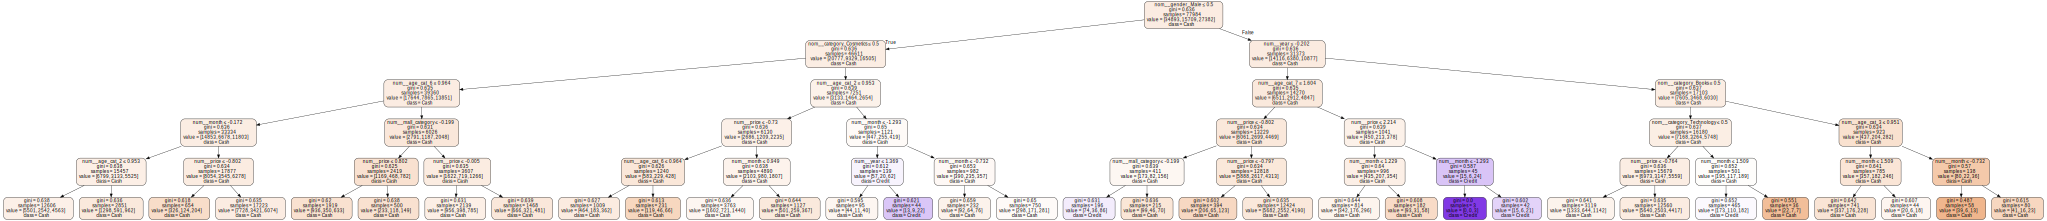

In [213]:
from sklearn.tree import export_graphviz
import graphviz 

rf = Pipeline([
    ("preprocessor",preprocessor),
    ("classifier",DecisionTreeClassifier(max_depth=5,random_state=42))
])

# Run the grid search
rf.fit(dev_X, dev_y)

dot_data = export_graphviz(rf.named_steps['classifier'], out_file=None,
                           feature_names=preprocessor.get_feature_names_out(), class_names=['Cash','Debit','Credit'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree', format='png')
graph

In [212]:
# Extract feature importances from the decision tree model
importances = rf.named_steps['classifier'].feature_importances_

# Get the names of the preprocessed features
features = preprocessor.get_feature_names_out()

# Create a dictionary of feature names and importances
feature_importances = dict(zip(features, importances))
sorted_dict = dict(sorted(feature_importances.items(), key=lambda item: item[1]))

# Print the feature importances as text
for feature, importance in sorted_dict.items():
    print(f"{feature}: {importance}")

num__quantity: 0.0
num__age_cat_1: 0.0
num__age_cat_4: 0.0
num__age_cat_5: 0.0
nom__gender_Female: 0.0
nom__category_Clothing: 0.0
nom__category_Food & Beverage: 0.0
nom__category_Shoes: 0.0
nom__category_Souvenir: 0.0
nom__category_Toys: 0.0
num__age_cat_7: 0.01934075020357669
nom__gender_Male: 0.02370822127664831
nom__category_Technology: 0.03471148816921488
num__age_cat_3: 0.04239145683688853
nom__category_Cosmetics: 0.04362555597680606
nom__category_Books: 0.05037797417864742
num__year: 0.055499350556189896
num__age_cat_6: 0.06583957103834663
num__age_cat_2: 0.07228183813979154
num__mall_category: 0.07505871161898242
num__price: 0.2577431368645146
num__month: 0.259421945140393


<h3> Checking on the test set </h3>